In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd, tweepy
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import os
import re
import csv
import codecs 
import warnings
import random 
import itertools
from time import time
from sklearn.metrics import confusion_matrix
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


import re, nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

%matplotlib inline
%config IPCompleter.greedy=True
pd.set_option('display.max_colwidth', None)
#References https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
#           https://nlp.stanford.edu/projects/glove/
#           https://medium.com/@chaimgluck1/have-messy-text-data-clean-it-with-simple-lambda-functions-645918fcc2fc


In [ ]:
'''
df = pd.read_csv('02_Brexit_Tweets_19_20/tweets_sentiments.csv', 
                 encoding="utf-8",
                 usecols=[0, 13])

df['Label'].replace(["Positive", "Negative"],[1, 0], inplace=True)
'''

In [6]:
df = pd.read_csv('02_Brexit_Tweets_19_20/SPLIT_EVEN_LSTM1.csv', 
                 encoding="ISO-8859-1")

In [7]:
df = df[df.Label != "Neutral"]

In [8]:
df['Label'].value_counts()

1    981072
0    981072
Name: Label, dtype: int64

In [16]:
random.seed(50)
df.iloc[random.sample(range(1, 1209783), 10), :]

,Content,Label
899631,"@andrew_lilico May doesn't need to 'force' her deal, she just needs to run out of time and options. And she is doing exactly that. #Brexit",1
207911,"""Lock the doors"" lyder det fra #Bercow @CommonsSpeaker - vil et flertal mon godkende den stramme tidsplan for at kunne fÃÂ¥ #Brexit i hus inden 31. oktober?\nVi fÃÂ¸lger spÃÂ¦ndte med live pÃÂ¥ @berlingske #eudk Ã°ÂÂÂªÃ°ÂÂÂºÃ°ÂÂÂªÃ°ÂÂÂºÃ°ÂÂÂªÃ°ÂÂÂº\n\nhttps://t.co/lt4uooySro https://t.co/tMiHG7Ok9G",1
825458,@Turloughc @AnneSta46031029 @johnredwood Nothing to do with the #Brexit vote...Bulk dry index has been falling for ages - global trade slowdown is inevitable (&amp; another financial crash on the way).\n\nEU is going to be hardest hit...&amp; we'd be better off if we're not included in the carnage...&amp; *on the hook* for bailouts.,1
740233,@Nigel_Farage @brexitparty_uk Love the new bus @Nigel_Farage and my favourite colour too. \n#BrexitParty standing up for democracy. Change is certainly needed in this country. #Brexit,1
131995,"UK Tory government wants to #Brexit and trade with China, America etc. they don't care what those countries have been up to. They may even start similar camps here in UK. All the Tories want is money, money, money. https://t.co/ltK4LE6Bif",1
981274,@cliodiaspora @DKShrewsbury is an embarrassment even to the fools and self-serving media and MPs stoking this nationalistic rubbish\nWe will continue to fight to stop #brexit and if we fail we'll fight to #return\nOur future is in the EU with our friends &amp; neighbours from all Europe\n#StopBrexit,0
347623,"@BorisJohnson lost over 40 Billions UK pounds in shares in the stock market this month alone, this is economic terrorism, they're trying to tie that to the flu virus, but it's #Brexit, also Trillions have left UK since 2016. Tories are economic arsonists. - @GoldmanSachs @Davos",1
1121314,The latest Veritas International! https://t.co/ljw6Nd4mmm #brexit #governmentshutdown,0
917453,They keep saying we will stop free movement is this a secret the only reason we have free movement is the goverment not acting on EU laws to stop free movement here people cant move here without a job enough money for 3 months and insurance its all a lie #Brexit #AprilFools,1
273292,Well done to #GrahamNorton for playing #tragedy at the start of his radio show this morning. It really is #Brexit #Brexittragedy,1


In [17]:
tokenizer = TweetTokenizer(strip_handles=True)
stop_words = set(stopwords.words('english'))
corpus = []

In [18]:
def clean(tweet): 
            
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)  
    
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"yrs", "years", tweet)
    tweet = re.sub(r"hrs", "hours", tweet)
    tweet = re.sub(r"2morow|2moro", "tomorrow", tweet)
    tweet = re.sub(r"2day", "today", tweet)
    tweet = re.sub(r"4got|4gotten", "forget", tweet)
    tweet = re.sub(r"b-day|bday", "b-day", tweet)
    tweet = re.sub(r"mother's", "mother", tweet)
    tweet = re.sub(r"mom's", "mom", tweet)
    tweet = re.sub(r"dad's", "dad", tweet)
    tweet = re.sub(r"hahah|hahaha|hahahaha", "haha", tweet)
    tweet = re.sub(r"lmao|lolz|rofl", "lol", tweet)
    tweet = re.sub(r"thanx|thnx", "thanks", tweet)
    tweet = re.sub(r"goood", "good", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    # Urls
    tweet = re.sub(r"http\S+", "", tweet)
    # Numbers
    tweet = re.sub(r'[0-9]', '', tweet)
    # Eliminating the mentions
    tweet = re.sub("(@[A-Za-z0-9_]+)","", tweet)
    # Remove punctuation and special chars (keep '!')
    for p in string.punctuation.replace('!', ''):
        tweet = tweet.replace(p, '')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')
        
    # Tokenize
    tweet_words = tokenizer.tokenize(tweet)
    
    # Eliminating the word if its length is less than 3
    tweet = [w for w in tweet_words if len(w)>2]
    
    # remove stopwords
    tweet = [w.lower() for w in tweet_words if not w in stop_words]  
    
    corpus.append(tweet)
    
    # join back
    tweet = ' '.join(tweet)
        
        
    return tweet  

In [19]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [20]:
def convert_abbrev_in_text(tweet):
    t=[]
    words=tweet.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t) 

In [21]:
%%time

df['Content']=df['Content'].apply(lambda s : clean(s))
df['Content']=df['Content'].apply(lambda s : convert_abbrev_in_text(s))

Wall time: 9min 35s


In [23]:
#df = df.to_csv('Brexit_Tweets_19_20/cleaned_sentimentLSTM.csv', index=False)
df = pd.read_csv('02_Brexit_Tweets_19_20/cleaned_sentimentLSTM.csv')

In [24]:
embedding_dim = 100    # glove6b100
max_length = 280         # max lenght of a tweet
trunc_type='post'      # it will cut the tweet if it is longer than 20
padding_type='post'    # it will add zeros at the end the tweets if is smaller than 20
oov_tok = "<OOV>"      # for unseen words 
training_size= 1962144
test_portion=.025

In [25]:
num_sentences = 0
corpus = []
with codecs.open("02_Brexit_Tweets_19_20/cleaned_sentimentLSTM.csv",encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[0])
        this_label=row[1]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [26]:
sentences=[]
labels=[]

random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [27]:
#GloVe is an unsupervised learning algorithm for obtaining vector representations for words
embeddings_index = {};
with open('02_Brexit_Tweets_19_20/glove.6B.100d.txt', encoding = "utf-8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [28]:
print(embeddings_matrix.shape)

(546787, 100)


In [29]:
def cosine_similarity(u, v):
    distance = 0.0
    # the dot product between u and v 
    dot = np.dot(u, v)
    # the L2 norm of u 
    norm_u = np.sqrt(np.sum((u)**2))
    
    # the L2 norm of v 
    norm_v = np.sqrt(np.sum((v)**2))
    # the cosine similarity defined by formula 
    cosine_similarity = dot/(norm_u*norm_v)
    
    return cosine_similarity

In [39]:
conservative = embeddings_index["conservative"]
right = embeddings_index["right-wing"]
queen = embeddings_index["queen"]
king = embeddings_index["king"]
woman = embeddings_index["woman"]
man = embeddings_index["man"]

print("cosine_similarity(right, conservative) = ", cosine_similarity(right,conservative))
print("cosine_similarity(king, queen) = ",cosine_similarity(queen,king))
print("cosine_similarity(woman, man) = ",cosine_similarity(woman,man))

cosine_similarity(right, conservative) =  0.64127177
cosine_similarity(king, queen) =  0.750769
cosine_similarity(woman, man) =  0.83234936


In [40]:

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(LSTM(units=64, return_sequences=True)),
        tf.keras.layers.Bidirectional(LSTM(units=128)),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    
    num_epochs = 15
    
    training_padded = np.array(training_sequences)
    training_labels = np.array(training_labels)
    testing_padded = np.array(test_sequences)
    testing_labels = np.array(test_labels)
    
    history = model.fit(training_padded, 
                        training_labels, 
                        epochs=num_epochs, 
                        validation_data=(testing_padded, testing_labels),
                        batch_size = 256,
                        verbose=1)
    
    print("Training Complete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 280, 100)          54678700  
_________________________________________________________________
dropout (Dropout)            (None, 280, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 280, 128)          84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 55,042,861
Trainable params: 364,161
Non-trainable params: 54,678,700
______________________________________

<Figure size 432x288 with 0 Axes>

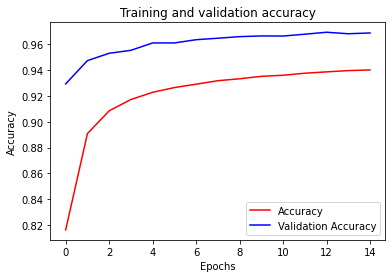

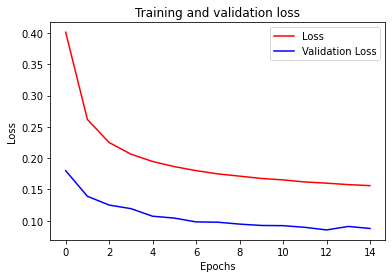

<Figure size 432x288 with 0 Axes>

In [42]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs


# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()


# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()